# import data

In [2]:
import numpy as np

In [3]:
with open('datasets/collaboration.edgelist.txt', 'r') as f:
    txt = f.readlines()
    txt = list(map(lambda x: x.replace('\n', '').split('\t'), txt))
    txt = list(map(lambda x: [int(x[0]), int(x[1])], txt))
    txt = np.array(txt)

In [4]:
num_node = np.max(txt) + 1

In [5]:
from scipy.sparse import dok_matrix
from scipy import float32
S = dok_matrix((num_node,num_node), dtype=float32)
for i in txt:
    S[i[0],i[1]] = 1.
S = S.tocsr()

# measures

(a) the degree distribution (fit a line and find the slope),

(b) clustering coefficient distribution (compute the average as well),

(c) shortest paths distribution (compute the average as well),

(d) number of connected components, the portion of nodes that are in the GCC

(e) eigenvalue distribution (compute the spectral gap),

(f) degree correlations (plot as scatter di vs dj , also report the overall correlation).

(g) degree-clustering coefficient relation (plot as scatter di vs ci)

### (a) degree distribution

In [34]:
degrees = np.asarray(S.sum(axis=1)).reshape(-1)

In [23]:
from collections import Counter

In [108]:
degree_counts = np.array([[np.log(d + 1), np.log(c)] for (d, c) in  Counter(degrees).items()])

In [109]:
import matplotlib.pyplot as plt

In [110]:
def least_squares(x, y):
    x_ = np.concatenate((x, np.ones(x.shape)), axis=1)
    return np.dot(np.linalg.inv(np.dot(x_.T, x_)), np.dot(x_.T, y))

In [296]:
x, y = degree_counts[:,0].reshape(-1,1), degree_counts[:,1].reshape(-1,1)

In [297]:
[slope, bias] = least_squares(x, y).reshape(-1).tolist()

In [298]:
def infer_y(x, slope, bias):
    return x * slope + bias

In [299]:
v_infer_y = np.vectorize(lambda x: infer_y(x, slope, bias))

In [300]:
inferred_y = v_infer_y(x)

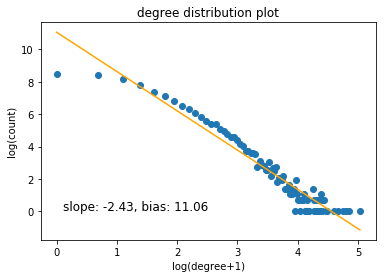

In [301]:
plt.scatter(x, y)
plt.plot(x, inferred_y, c='orange')
plt.text(.1, .1, 'slope: {}, bias: {}'.format(round(slope, 2), round(bias, 2)), 
         fontsize=12)
plt.xlabel('log(degree+1)')
plt.ylabel('log(count)')
plt.title('degree distribution plot')
plt.show()

### (b) clustering coefficients

In [174]:
S_3 = S.dot(S).dot(S)

In [175]:
clusterings = np.nan_to_num(S_3.diagonal() / (degrees * (degrees - 1)))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [186]:
clustering_mean = np.mean(clusterings)

In [177]:
clustering_counts = np.array([[cl, np.log(c)] \
    for (cl, c) in  Counter(clusterings).items()])




In [302]:
x, y = clustering_counts[:,0].reshape(-1,1), \
    clustering_counts[:,1].reshape(-1,1)

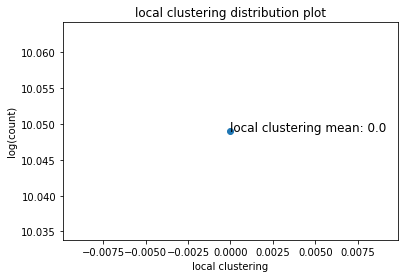

In [303]:
plt.scatter(x, y)
plt.text(x[0], y[0]  , 'local clustering mean: {}'.format(round(clustering_mean,2)), 
         fontsize=12)
plt.xlabel('local clustering')
plt.ylabel('log(count)')
plt.title('local clustering distribution plot')
plt.show()

### (c) shortest path distribution

In [250]:
from collections import defaultdict

In [251]:
row_nonzero, col_nonzero = S.nonzero()

In [252]:
aja_list = defaultdict(list)

In [253]:
for ind, i in enumerate(row_nonzero):
    aja_list[i].append(col_nonzero[ind])

In [254]:
from collections import deque

In [259]:
from tqdm import tqdm

In [260]:
all_dist = defaultdict(dict)
for i in tqdm(range(num_node)):
    all_dist[i][i] = 0
    neighs = aja_list[i]
    queue = deque()
    for j in neighs:
        all_dist[i][j] = 1
        queue.append((j, 1))
    if queue:
        while queue:
            cur_node, cur_dis = queue.popleft()
            neighs = aja_list[cur_node]
            for j in neighs:
                if j not in all_dist[i]:
                    all_dist[i][j] = cur_dis + 1
                    queue.append((j, cur_dis + 1))
 

100%|██████████| 23133/23133 [00:16<00:00, 1391.03it/s]


In [304]:
all_dist_vals = []
for i in all_dist:
    temp = all_dist[i]
    for j in temp:
        all_dist_vals.append(temp[j])

In [314]:
shortest_path_mean = np.mean(all_dist_vals)

In [306]:
inf_dist_count = num_node * num_node - len(all_dist_vals)

In [307]:
all_dist_val_counts = Counter(all_dist_vals)
# all_dist_val_counts[num_node] = inf_dist_count

In [308]:
all_dist_val_counts = np.array([[np.log(pl + 1), np.log(c)] \
    for (pl, c) in  all_dist_val_counts.items()])


In [309]:
x, y = all_dist_val_counts[:,0].reshape(-1,1), all_dist_val_counts[:,1].reshape(-1,1)

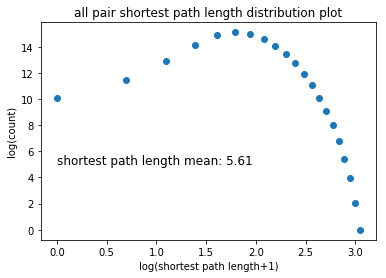

In [315]:
plt.scatter(x, y)
plt.text(x[0], y[0] // 2, 'shortest path length mean: {}'.format(round(shortest_path_mean,2)), 
         fontsize=12)
plt.xlabel('log(shortest path length+1)')
plt.ylabel('log(count)')
plt.title('all pair shortest path length distribution plot')
plt.show()

### (d) number of connected components, the portion of nodes that are in the GCC

In [316]:
all_comp = {}
base_comp = 0
for i in tqdm(range(num_node)):
    if i not in all_comp:
        all_comp[i] = base_comp
        neighs = aja_list[i]
        queue = deque()
        for j in neighs:
            all_comp[j] = base_comp
            queue.append((j, base_comp))
        if queue:
            while queue:
                cur_node, cur_dis = queue.popleft()
                neighs = aja_list[cur_node]
                for j in neighs:
                    if j not in all_comp:
                        all_comp[j] = base_comp
                        queue.append((j, base_comp))
        base_comp += 1


100%|██████████| 23133/23133 [00:00<00:00, 221930.85it/s]


In [323]:
components = np.array(list(all_comp.values()))

In [327]:
component_counter = Counter(components)

In [333]:
print('number of connected component: ', len(component_counter))
print('portion of nodes in giant connected component: ', round(max(component_counter.values()) / num_node, 2))

number of connected component:  4650
portion of nodes in giant connected component:  0.05


### (e) eigenvalue distribution (compute the spectral gap)

In [14]:
import scipy

In [32]:
from scipy.sparse import linalg, diags

In [39]:
degree_diagonal = diags(degrees, 0)

In [40]:
laplacian = degree_diagonal  - S

In [47]:
eigen_vals = linalg.eigsh(laplacian, k = num_node-1, return_eigenvectors=False)

In [48]:
eigen_vals = sorted(eigen_vals, reverse=True)

In [67]:
pos_eigen = [i for i in eigen_vals if i > 0]
eigen_gap = pos_eigen[-1]

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

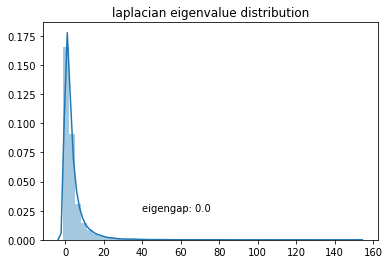

In [68]:
sns.distplot(eigen_vals)
plt.title('laplacian eigenvalue distribution')
plt.text(40, .025, 'eigengap: {}'.format(round(eigen_gap,2)))
plt.show()

### (f) degree correlations (plot as scatter di vs dj , also report the overall correlation).